# Benchmarking of serverless functions

Basic assumptions of the study:
- Period time of 2018 - 2024
- Searching for keywords `faas`, `function-as-a-service`, and `serverless`.
- At IEEExplore, search for conferences: BigData, CCGrid, IPDPS + Workshops, CLOUD, IC2E
- At Scopus, we search for ACM conferences: ASPLOS, EuroSys, Middleware + WoSC workshop, SOSP, SC, HPDC, SoCC

  > ASPLOS OR Middleware OR SOSP OR SC OR EuroSys OR HPDC OR SoCC OR ICPE
- At Scopus, we search for USENIX conferences: ATC, OSDI, NSDI

  > atc or nsdi or osdi

## Imports

In [202]:
import litstudy
import pandas as pd

## Dataset

For USENIX papers, Scopus does not return DOIs. Default IEEE implementation ignores publication source, so we extend the implementation.

In [203]:
from litstudy.types import Document, Author, DocumentSet, DocumentIdentifier, Affiliation
from litstudy.common import robust_open
import csv
import logging


class IEEEDocumentNew(litstudy.sources.ieee.IEEEDocument):
    def __init__(self, entry):
        super().__init__(entry)
        
    @property
    def publication_source(self) -> str:
        return self.entry.get("Publication Title")

    
def load_ieee_csv(path: str) -> DocumentSet:
    """Import CSV file exported from
    `IEEE Xplore <https://ieeexplore.ieee.org/search/searchresult.jsp>`_.
    """
    with robust_open(path) as f:
        lines = csv.DictReader(f)
        docs = [IEEEDocumentNew(line) for line in lines]
        return DocumentSet(docs)

In [204]:
docs_ieee = load_ieee_csv('data/ieeexplore-2025.06.24-11.34.17.csv')
print(len(docs_ieee), 'papers loaded from IEEE')

docs_acm = litstudy.load_scopus_csv('data/scopus.csv')
print(len(docs_acm), 'ACM papers loaded from Scopus')

docs_usenix = litstudy.load_scopus_csv('data/scopus_usenix.csv')
print(len(docs_usenix), 'USENIX papers loaded from Scopus')

docs = docs_ieee | docs_acm | docs_usenix
print(len(docs), 'papers loaded from CSV')
print(len(docs.unique()), 'unique papers loaded from CSV')

184 papers loaded from IEEE
335 ACM papers loaded from Scopus
63 USENIX papers loaded from Scopus
582 papers loaded from CSV
582 unique papers loaded from CSV


Check for years

In [205]:
docs = litstudy.DocumentSet([
    doc for doc in docs 
    if doc.publication_year and 2018 <= doc.publication_year <= 2024
])

print(len(docs), 'papers fitting the year.')

553 papers fitting the year.


## Dataset deduplication

First, we find all overall proceedings papers that are incorrectly included in the dataset.

In [223]:
wrong_titles = ["Proceedings of", "Companion of", "Workshop on", "Symposium"]

proceedings_papers = [d for d in docs if d.title and any(tit in d.title for tit in wrong_titles)]
print(f"Found {len(proceedings_papers)} papers with 'Proceedings of' in title")
[d.title for d in proceedings_papers]

Found 50 papers with 'Proceedings of' in title


['EuroSys 2024 - Proceedings of the 2024 European Conference on Computer Systems',
 'Mid4CC 2023 - Proceedings of the 2023 1st International Workshop on Middleware for the Computing Continuum, Part of: Middleware 2023',
 'MiddleWEdge 2023 - Proceedings of the 2nd International Workshop on Middleware for the Edge, Part of: ACM/IFIP Middleware 2023',
 'Middleware 2023 - Proceedings of the 24th ACM/IFIP International Middleware Conference',
 'Middleware Demos, Posters and Doctoral Symposium 2023: Proceedings of the 24th International Middleware Conference Demos, Posters and Doctoral Symposium, Part of: Middleware 2023',
 'GraphSys-2024: 2nd Workshop on Serverless, Extreme-Scale, and Sustainable Graph Processing Systems',
 'Middleware 2024 - Proceedings of the 25th ACM International Middleware Conference',
 'HPDC 2024 - Proceedings of the 33rd International Symposium on High-Performance Parallel and Distributed Computing',
 "12th International Workshop on Load Testing and Benchmarking of S

In [207]:
filtered_docs = docs - proceedings_papers
print(f"Left {len(filtered_docs)} documents")

Left 503 documents


Find all documents that do not have DOI - we will use DOI for removing duplicates (queries don't have perfect recall, sometimes asking for conferences A & B gives you a paper with conference C)

In [208]:
dois = [d.id.doi for d in filtered_docs]

In [209]:
missing_doi_docs = [d for d in filtered_docs if not d.id.doi or d.id.doi.strip() == '']
docs_with_doi = [d for d in filtered_docs if d.id.doi and d.id.doi.strip() != '']
print(f"Found {len(missing_doi_docs)} documents without DOI")
print(f"Found {len(docs_with_doi)} documents with DOI")

Found 53 documents without DOI
Found 450 documents with DOI


Missing DOI - it's all USENIX papers.

In [210]:
[x.publication_source for x in missing_doi_docs]

['Proceedings of the 18th USENIX Symposium on Networked Systems Design and Implementation, NSDI 2021',
 'Proceedings of the 15th USENIX Symposium on Operating Systems Design and Implementation, OSDI 2021',
 'HotCloud 2020 - 12th USENIX Workshop on Hot Topics in Cloud Computing, co-located with USENIX ATC 2020',
 'Proceedings of the 18th USENIX Symposium on Operating Systems Design and Implementation, OSDI 2024',
 'Proceedings of the 2023 USENIX Annual Technical Conference, ATC 2023',
 'Proceedings of the 2022 USENIX Annual Technical Conference, ATC 2022',
 'Proceedings of the 17th USENIX Symposium on Operating Systems Design and Implementation, OSDI 2023',
 'Proceedings of the 16th USENIX Symposium on Operating Systems Design and Implementation, OSDI 2022',
 'Proceedings of the 2024 USENIX Annual Technical Conference, ATC 2024',
 'Proceedings of the 2024 USENIX Annual Technical Conference, ATC 2024',
 'Proceedings of the 2022 USENIX Annual Technical Conference, ATC 2022',
 'Proceedings

To double check, we check the publication sources of documents with no DOI. If there's no overlap between unique non-USENIX papers and USENIX papers, then all records should be unique.

<AxesSubplot: title={'center': 'Publication source'}, xlabel='No. of documents'>

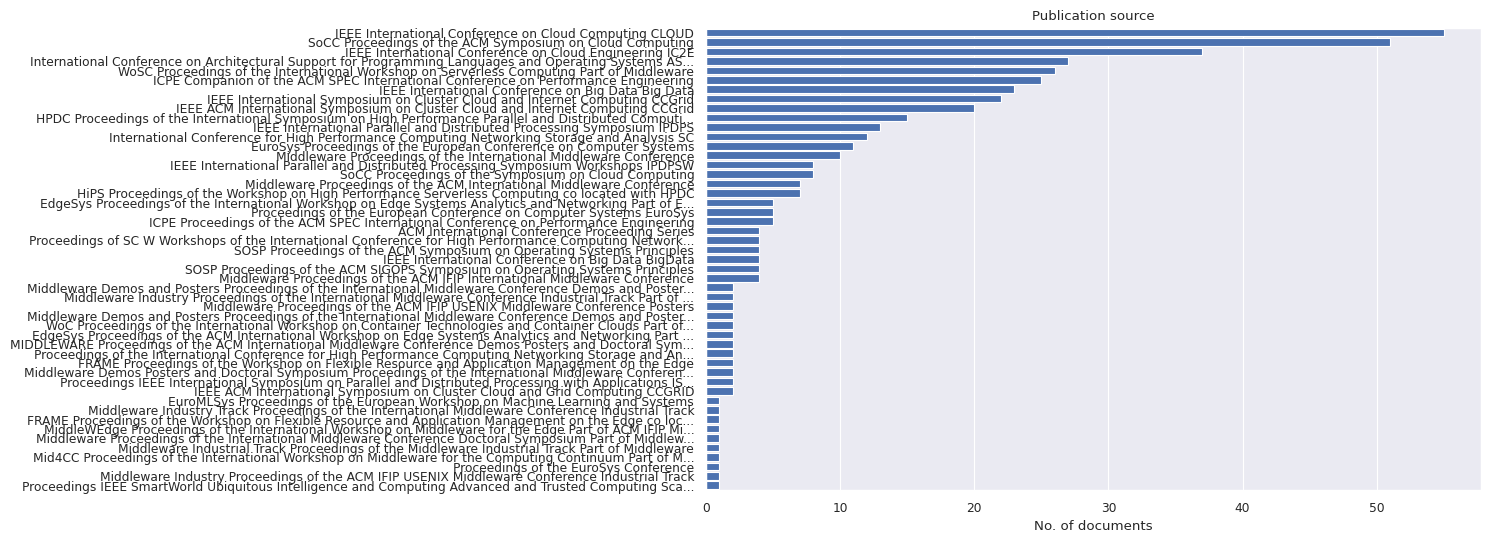

In [211]:
litstudy.plot_source_histogram(docs_with_doi, limit=50)

Looks good!

## Clean up dataset

Remove workshops and conferences incorrectly counted.

In [212]:
wrong_venues = ["EdgeSys", "HiPS", "HotCloud", "Mid4CC", "FRAME", "EuroMLSys", "IEEE SmartWorld", "HotEdge", "ISPA", "MiddleWEdge", "Demos", "Posters", "WoC", "WOC"]

to_remove_papers = [d for d in filtered_docs if d.publication_source and any(tit in d.publication_source for tit in wrong_venues)]
print(f"Found {len(to_remove_papers)} papers not fitting: {set([d.publication_source for d in to_remove_papers])}")

filtered_docs2 = filtered_docs - to_remove_papers

Found 41 papers not fitting: {'Middleware Demos, Posters and Doctoral Symposium 2023: Proceedings of the 24th International Middleware Conference Demos, Posters and Doctoral Symposium, Part of: Middleware 2023', 'WoC 2022 - Proceedings of the 8th International Workshop on Container Technologies and Container Clouds, Part of Middleware 2022', 'EdgeSys 2019 - Proceedings of the 2nd ACM International Workshop on Edge Systems, Analytics and Networking, Part of EuroSys 2019', 'WOC 2019 - Proceedings of the 2019 5th International Workshop on Container Technologies and Container Clouds, Part of Middleware 2019', 'HiPS 2021 - Proceedings of the 1st Workshop on High Performance Serverless Computing, co-located with HPDC 2021', 'Middleware 2021 Demos and Posters - Proceedings of the 2021 International Middleware Conference Demos and Posters', 'Mid4CC 2023 - Proceedings of the 2023 1st International Workshop on Middleware for the Computing Continuum, Part of: Middleware 2023', 'EdgeSys 2021 - Pro

In [213]:
len(filtered_docs2)

462

Custom filters for wrong matches.

In [222]:
wrong_titles = ["Invited Talk", "Demo"]

to_remove_papers = [d for d in filtered_docs2 if d.title and any(tit in d.title for tit in wrong_titles)]
print(f"Found {len(to_remove_papers)} papers not fitting: {set([d.title for d in to_remove_papers])}")

filtered_docs3 = filtered_docs2 - to_remove_papers
len(filtered_docs3)

Found 2 papers not fitting: {'ScaDL 2022 Invited Talk 2: AI/ML Pipelines using CodeFlare', 'Invited Talk 3'}


460

<AxesSubplot: title={'center': 'Publication source'}, xlabel='No. of documents'>

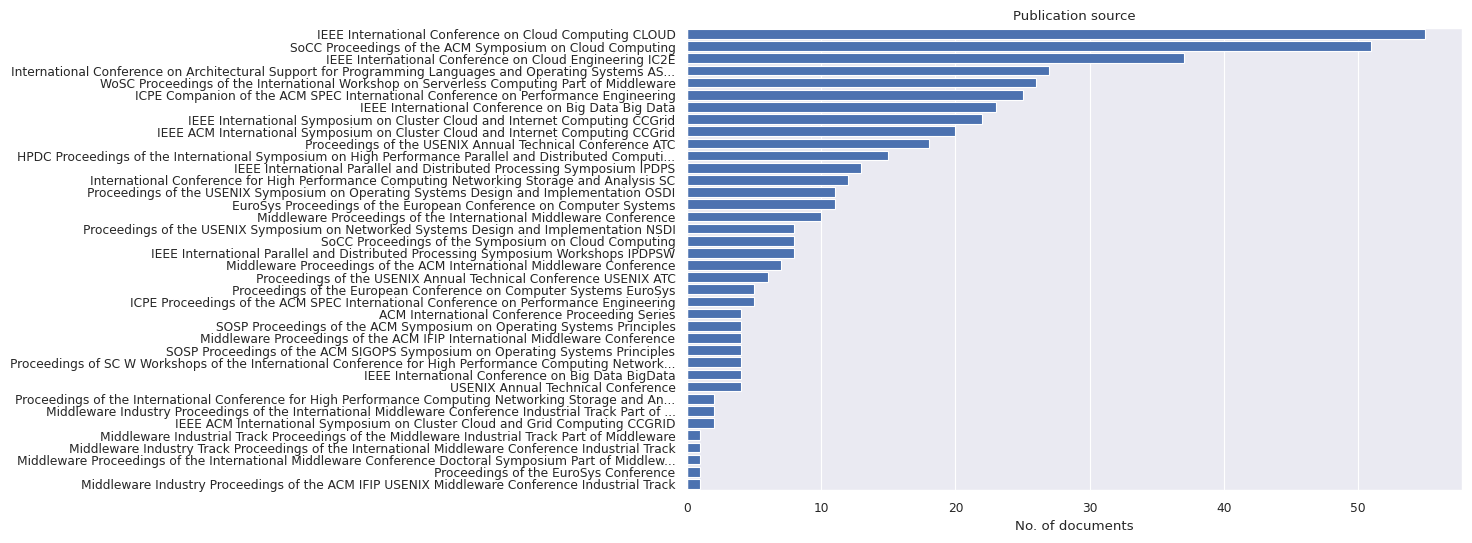

In [214]:
litstudy.plot_source_histogram(filtered_docs2, limit=70)

## Export Excel

In [242]:
data = []

for doc in filtered_docs3:
    
    venue = doc.publication_source
    year = doc.publication_year
    title = doc.title
    doi = doc.id.doi
    
    data.append({
        'Year': year,
        'Venue': venue,
        'Title': title,
        'DOI': doi
    })

df = pd.DataFrame(data)
df = df.sort_values('Year')

# Now add benchmark columns
df['SeBS'] = None
df['FunctionBench'] = None
df['ServerlessBench'] = None
df['vSwarm'] = None
df['Triggerbench'] = None
df['Servibench'] = None
df['Custom'] = None
df['Other (list)'] = None

with pd.ExcelWriter("files.xlsm", engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='Papers', index=False)
    
    workbook = writer.book
    worksheet = writer.sheets['Papers']

    title_column = list(worksheet.columns)[2]
    
    column_lengths = [100, 40] + [30] * 8
    
    for idx, col in enumerate(list(worksheet.columns)[2:12]):
        max_length = 0
        column_letter = col[0].column_letter
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = min(max_length + 2, column_lengths[idx]) # 50 chars
        worksheet.column_dimensions[column_letter].width = adjusted_width